<b><font size="6">New York City Taxi Fare Prediction Playground Competition</br>
    Create Linear Regression Models</font></b>

**PDS ILV bds19: Summer School**  
**Data Science & Business Analytics**

Autor: Thomas Schrittwieser, DS191004  
Datum: 2020-07-20

---

In [48]:
# load some default Python modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
#from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.pipeline import Pipeline
#from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
plt.style.use('seaborn')

## Configuration

In [49]:
# Configuration

show_diagrams = 1     # If you want to see the diagrams, choose show_diagrams = 1
random_sample_df = 1  # If you want to work with a sample dataframe, choose random_sample_df = 1
write_to_feather = 0  # If you want to store the cleaned file as feather file, choose write_to_feather = 1

# Coordinates of New York City
nyc = (-74.0063889, 40.7141667)

# input filename
input_file = '../data/new-york-city-taxi-fare-prediction/nyc_taxi_data_cleaned.feather'

## Functions

In [50]:
# Calculate the distance in miles between locations in lon,lat coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

In [51]:
# define some handy analysis support function

def plot_prediction_analysis(y, y_pred, figsize=(10,4), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].scatter(y, y_pred)
    mn = min(np.min(y), np.min(y_pred))
    mx = max(np.max(y), np.max(y_pred))
    axs[0].plot([mn, mx], [mn, mx], c='red')
    axs[0].set_xlabel('$y$')
    axs[0].set_ylabel('$\hat{y}$')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    axs[0].set_title('rmse = {:.2f}, evs = {:.2f}'.format(rmse, evs))
    
    axs[1].hist(y-y_pred, bins=50)
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('$y - \hat{y}$')
    axs[1].set_title('Histrogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
    
    if title!='':
        fig.suptitle(title)

In [52]:
# calculates the scores of the regression model
def calc_scores(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    reg_train_score = model.score(X_train, y_train)
    reg_test_score = model.score(X_test, y_test)
    r2_train_score = r2_score(y_train, y_train_pred)
    r2_test_score = r2_score(y_test, y_test_pred)
    return (reg_train_score, reg_test_score, r2_train_score, r2_test_score)

In [53]:
# Format the score in percent for output
def format_score(score):
    return (f'{score*100:.2f}%')

In [65]:
# Output the model scores 
def print_scores(model, model_name, scores):
    print(f'Model:\n{model}\n')

    print(f'{model_name} Score:')
    print(f'Train Score: {format_score(scores[0])}')
    print(f'Test Score: {format_score(scores[1])}')

    print('\nR^2 Score:')
    print(f'On train data: {format_score(scores[2])}')
    print(f'on test data: {format_score(scores[3])}')

In [55]:
# Function to print best hyperparamaters: 
def print_best_params(gd_model):
    param_dict = gd_model.best_estimator_.get_params()
    model_str = str(gd_model.estimator).split('(')[0]
    print("\n*** {} Best Parameters ***".format(model_str))
    for k in param_dict:
        print("{}: {}".format(k, param_dict[k]))

# Reading data and first exploration

In [6]:
# load the feather-file with the cleaned taxi data which was created in file '2_NYC Taxi Fare - Cleaning.ipynb'
df = pd.read_feather(input_file)
df.drop(columns=['index'], inplace=True)

In [7]:
# Create a random sample dataframe with 2_000_000 elements
if random_sample_df == 1:
    df = df.sample(n=5_000_000, random_state=1)

# Save the shape of the initial dataframe for further use
df_initial_shape = df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000000 entries, 28191451 to 39918046
Data columns (total 14 columns):
 #   Column             Dtype              
---  ------             -----              
 0   fare_amount        float32            
 1   pickup_datetime    datetime64[ns, UTC]
 2   pickup_longitude   float32            
 3   pickup_latitude    float32            
 4   dropoff_longitude  float32            
 5   dropoff_latitude   float32            
 6   passenger_count    uint8              
 7   distance           float32            
 8   price/mile         float32            
 9   year               uint16             
 10  month              uint8              
 11  day                uint8              
 12  wday               uint8              
 13  hour               uint8              
dtypes: datetime64[ns, UTC](1), float32(7), uint16(1), uint8(5)
memory usage: 243.2 MB


In [8]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,price/mile,year,month,day,wday,hour
28191451,9.5,2012-10-28 12:44:00+00:00,-73.967438,40.759869,-73.992729,40.742847,1,1.770742,5.364984,2012,10,28,6,12
25762660,7.0,2015-02-22 21:16:00+00:00,-73.991203,40.751041,-73.970543,40.748905,1,1.091447,6.413502,2015,2,22,6,21
4513682,8.0,2013-10-31 22:02:00+00:00,-73.981300,40.742939,-73.978195,40.729141,5,0.967095,8.272200,2013,10,31,3,22
3438882,5.7,2011-03-11 10:59:00+00:00,-73.998436,40.740383,-74.007851,40.724018,1,1.233487,4.621047,2011,3,11,4,10
16164427,13.5,2013-09-08 09:59:00+00:00,-73.949005,40.797157,-73.986824,40.755821,1,3.474545,3.885400,2013,9,8,6,9


In [9]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,price/mile,year,month,day,wday,hour
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,9.808908e+00,-7.255847e+01,4.271819e+01,-7.255717e+01,4.271832e+01,1.688620e+00,1.774750e+00,6.838861e+00,2.011739e+03,6.256098e+00,1.570661e+01,3.051133e+00,1.350978e+01
std,6.230247e+00,1.415393e+00,1.990172e+00,1.414514e+00,1.989168e+00,1.305203e+00,1.525485e+00,2.797424e+00,1.866109e+00,3.440110e+00,8.687291e+00,1.945713e+00,6.571555e+00
min,2.500000e+00,-7.449245e+01,4.050117e+01,-7.449392e+01,4.050045e+01,1.000000e+00,1.251411e-01,2.000063e+00,2.009000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399277e+01,4.073703e+01,-7.399187e+01,4.073631e+01,1.000000e+00,7.980751e-01,4.847474e+00,2.010000e+03,3.000000e+00,8.000000e+00,1.000000e+00,9.000000e+00
50%,8.100000e+00,-7.398265e+01,4.075308e+01,-7.398116e+01,4.075376e+01,1.000000e+00,1.309863e+00,6.199891e+00,2.012000e+03,6.000000e+00,1.600000e+01,3.000000e+00,1.400000e+01
75%,1.170000e+01,-7.397060e+01,4.076673e+01,-7.396734e+01,4.076822e+01,2.000000e+00,2.227077e+00,8.090645e+00,2.013000e+03,9.000000e+00,2.300000e+01,5.000000e+00,1.900000e+01
max,2.725400e+02,-7.286425e+01,4.177475e+01,-7.286469e+01,4.174427e+01,6.000000e+00,5.503373e+01,1.999994e+01,2.015000e+03,1.200000e+01,3.100000e+01,6.000000e+00,2.300000e+01


# Generate baseline model and submission

In [10]:
# Create a new dataframe
df_model = pd.DataFrame()
df_model['distance_miles'] = df['distance']
df_model['dropoff_to_center_miles'] = distance(nyc[1], nyc[0], df['dropoff_latitude'], df['dropoff_longitude'])
df_model['pickup_to_center_miles'] = distance(nyc[1], nyc[0], df['pickup_latitude'], df['pickup_longitude'])
df_model['passenger_count'] = df['passenger_count']
df_model['year'] = df['year']
df_model['wday'] = df['wday']
df_model['hour'] = df['hour']
df_model['fare_amount'] = df['fare_amount']

## Correlation Matrix

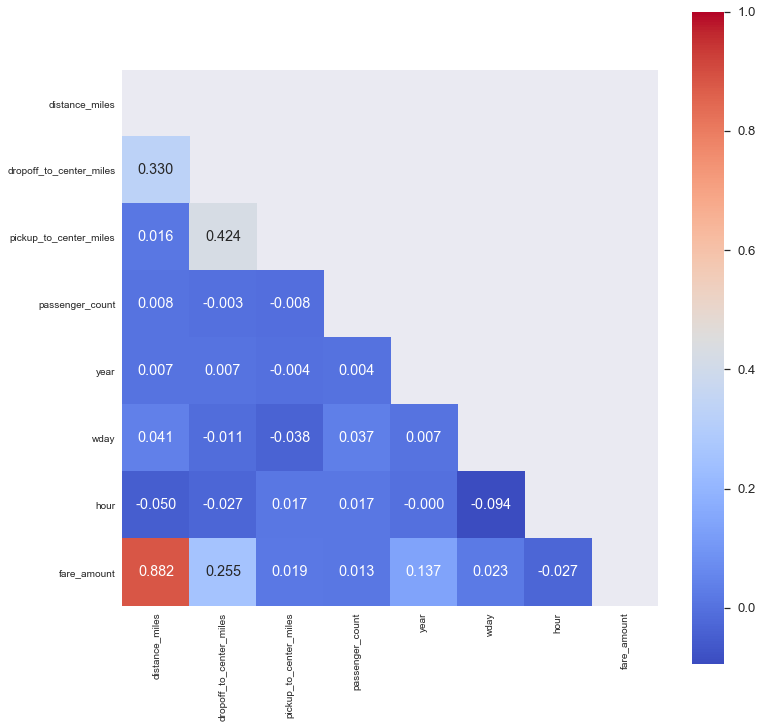

In [11]:
# Create correlation matrix
corrMatrix = df_model.corr()
matrix = np.triu(df_model.corr())
#matrix = np.tril(df_model.corr())

# Show correlation matrix
if show_diagrams == 1:
    fig, ax = plt.subplots(figsize=(12,12)) 
    sns.set(font_scale=1.2)
    sns.heatmap(corrMatrix, annot=True, cmap= 'coolwarm', fmt=".3f", square=True, mask = matrix);

As you can see in the correlation matrix above, the strongest correlation exists between `fare_amount` and `distance_miles`.

## Model

Based on the correlation matrix, I would start with the following model:

$$
\text{fare amount} \text{ ~ } \text{distance}, \text{dropoff_to_center}, \text{year}
$$

In [12]:
df_model.columns

Index(['distance_miles', 'dropoff_to_center_miles', 'pickup_to_center_miles',
       'passenger_count', 'year', 'wday', 'hour', 'fare_amount'],
      dtype='object')

In [13]:
model_columns = ['distance_miles', 'dropoff_to_center_miles', 'year']

# X_array with features
X = df_model[model_columns]

# y_array with the label "fare_amount" 
y = df_model['fare_amount'].copy()

print(f'Size of X: {X.shape}')
print(f'Size of y: {y.shape}')

Size of X: (5000000, 3)
Size of y: (5000000,)


# Split data in train and test data

In [14]:
#Split the dataframe into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [15]:
# standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # apply same transformation to test data

## Linear Regression

In [56]:
#fit model
lr = LinearRegression().fit(X_train, y_train)

In [57]:
# create coefficient dataframe
pd.DataFrame(lr.coef_, X.columns, columns=['Coefficient'])
#coeff_df

,Coefficient
distance_miles,3.656501
dropoff_to_center_miles,-0.134275
year,0.438858


The coefficients show that 
- the `fare_amount` increases by ~3.6 USD when the `distance_miles` (air-line distance) increases by 1
- the `fare_amount` increases each `year` by ~0.4 USD

In [58]:
print(f'lr.intercept_: {lr.intercept_}\n')

lr.intercept_: -879.0723928355009



In [66]:
# Calculate the model scores
scores = calc_scores(lr, X_train, X_test, y_train, y_test)

In [68]:
# Output of the model scores
print_scores(lr, 'Linear Regression', scores)

Model:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Linear Regression Score:
Train Score: 79.74%
Test Score: 79.72%

R^2 Score:
On train data: 79.74%
on test data: 79.72%


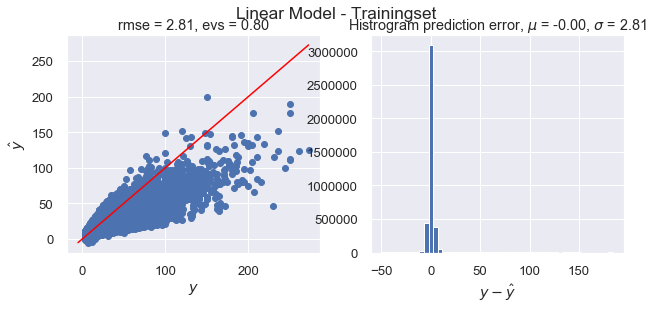

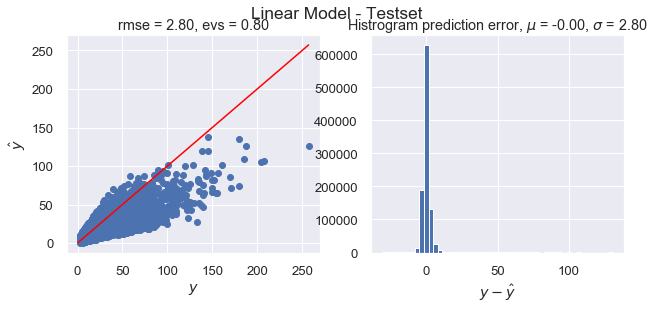

In [22]:
if show_diagrams == 1:
    model_lin = Pipeline((
            ("standard_scaler", StandardScaler()),
            ("lin_reg", LinearRegression()),
        ))
    model_lin.fit(X_train, y_train)

    y_train_pred = model_lin.predict(X_train)
    plot_prediction_analysis(y_train, y_train_pred, title='Linear Model - Trainingset')

    y_test_pred = model_lin.predict(X_test)
    plot_prediction_analysis(y_test, y_test_pred, title='Linear Model - Testset')

## Ridge regression

In [ ]:
# Parameters
param_grid_ridge = dict(alpha=[0.001, 0.01, 0.1, 1.0])

reg = GridSearchCV(Ridge(), param_grid=param_grid_ridge, cv=5, verbose=2)

#fit model
reg = reg.fit(X_train_scaled,y_train.values.ravel())

# print score
print('\n\nridge train score %.3f, ridge test score: %.3f' % (
    reg.score(X_train_scaled,y_train),
    reg.score(X_test_scaled, y_test)))

#print(reg.best_estimator_.get_params())

print_best_params(reg)

In [69]:
#fit model with the best parameters from the GridSearchCV
reg = Ridge(alpha=1).fit(X_train_scaled, y_train)

In [70]:
# Calculate the model scores
scores = calc_scores(reg, X_train_scaled, X_test_scaled, y_train, y_test)

In [71]:
# Output of the model scores
print_scores(reg, 'Ridge Regression', scores)

Model:
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

Ridge Regression Score:
Train Score: 79.74%
Test Score: 79.72%

R^2 Score:
On train data: 79.74%
on test data: 79.72%


In [80]:
# create coefficient dataframe
pd.DataFrame(reg.coef_, X.columns, columns=['Coefficient'])
#coeff_df

,Coefficient
distance_miles,5.595553
dropoff_to_center_miles,-0.256570
year,0.819080


In [81]:
reg.intercept_

9.830530208440848

## SGD (Stochastic Gradient Descent) Regressor

In [ ]:
# Parameters
param_grid_sgd = dict(alpha=[0.0001, 0.001],
                        max_iter=[50, 100],
                        eta0=[0.01, 0.1])

sgd = GridSearchCV(SGDRegressor(), param_grid=param_grid_sgd, cv=5, verbose=3)

#fit model
sgd = sgd.fit(X_train_scaled,y_train.values.ravel())

#print score
print('\n\nSGD train score %.3f, SGD test score: %.3f' % (
    sgd.score(X_train_scaled,y_train),
    sgd.score(X_test_scaled, y_test)))

#print(sgd.best_estimator_.get_params())

print_best_params(sgd)

In [82]:
# fit model with the best parameters from the GridSearchCV
sgd = SGDRegressor(alpha=.0001, max_iter=100, eta0 = .01).fit(X_train_scaled, y_train)

In [83]:
# Calculate the model scores
scores = calc_scores(sgd, X_train_scaled, X_test_scaled, y_train, y_test)

In [84]:
# Output of the model scores
print_scores(sgd, 'SGD Regressor', scores)

Model:
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=100,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

SGD Regressor Score:
Train Score: 79.73%
Test Score: 79.71%

R^2 Score:
On train data: 79.73%
on test data: 79.71%


In [78]:
# create coefficient dataframe
pd.DataFrame(sgd.coef_, X.columns, columns=['Coefficient'])
#coeff_df

,Coefficient
distance_miles,5.573389
dropoff_to_center_miles,-0.237382
year,0.864855


In [79]:
sgd.intercept_

array([9.84425134])

## Random Forest

In [ ]:
forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)

#fit model
forest.fit(X_train_scaled,y_train.values.ravel())

In [76]:
# Calculate the model scores
scores = calc_scores(forest, X_train_scaled, X_test_scaled, y_train, y_test)

In [77]:
# Output of the model scores
print_scores(forest, 'Random Forest', scores)

Model:
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

SGD Regressor Score:
Train Score: 79.73%
Test Score: 79.71%

R^2 Score:
On train data: 79.73%
on test data: 79.71%


# Delete dataframes to release memory

In [ ]:
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs)

In [ ]:
del corrMatrix